In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

from medmnist import PathMNIST
from medmnist import INFO

In [2]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.2])
])

train_dataset = PathMNIST(split='train', download=True, transform=data_transform)
val_dataset = PathMNIST(split='val', download=False, transform=data_transform)
test_dataset = PathMNIST(split='test', download=False, transform=data_transform)

Using downloaded and verified file: C:\Users\jaint\.medmnist\pathmnist.npz


In [3]:
info = INFO['pathmnist']  # get some metadata of PathMNIST

batch_size = 32
n_channels, n_classes = info['n_channels'], len(info['label'])

In [4]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*batch_size, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*batch_size, shuffle=False)

In [5]:
print(next(iter(train_loader)))

[tensor([[[[ 1.3824,  0.8137,  1.1275,  ...,  0.8529,  0.9314,  1.7549],
          [ 1.2647,  1.0294,  1.1863,  ...,  0.4804,  1.0294,  2.0098],
          [ 1.7745,  1.6373,  0.7157,  ...,  1.2059,  1.5392,  1.2647],
          ...,
          [ 1.0294,  1.1078,  0.6373,  ...,  0.5392,  0.3431,  0.7549],
          [ 0.8333,  0.7549,  0.5980,  ...,  0.3039,  0.5980,  0.3039],
          [ 0.8137,  0.4216,  0.4608,  ...,  0.4412,  0.8725,  1.2843]],

         [[ 0.6569, -0.0882,  0.2451,  ..., -0.1275,  0.0294,  1.1275],
          [ 0.3039,  0.0490,  0.1471,  ..., -0.6176,  0.0686,  1.4412],
          [ 0.9314,  0.8333, -0.3627,  ...,  0.1863,  0.5000,  0.2255],
          ...,
          [-0.0490,  0.2059, -0.3824,  ..., -0.5980, -0.8529, -0.1863],
          [-0.1078, -0.2059, -0.5000,  ..., -0.8333, -0.3824, -0.7157],
          [-0.2059, -0.7157, -0.5196,  ..., -0.6765, -0.0490,  0.4020]],

         [[ 1.3235,  0.7549,  1.0098,  ...,  0.7745,  0.8333,  1.6569],
          [ 1.1275,  0.9118, 

In [6]:
print(n_channels, n_classes)

3 9


In [7]:
class PathNet(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(PathNet, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=num_channels, out_channels=16, kernel_size=5),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU())

        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU())

        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU())

        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU())

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Sequential(nn.Linear(in_features=64 * 8 * 8, out_features=512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2))
        self.fc2 = nn.Sequential(nn.Linear(in_features=512, out_features=128),
                                 nn.ReLU(),
                                 nn.Dropout(0.2))
        self.fc3 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool((self.conv4(x)))

        x = x.view(-1, 64 * 8 * 8)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x  # not applying softmax


In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PathNet(n_channels, n_classes).to(device)
criterion = nn.CrossEntropyLoss()

In [31]:
num_epochs = 10
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [32]:
losses = []
val_accuracies = []

for epoch in range(num_epochs):

    loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = 0.

    model.train()
    for images, labels in loop:
        images = images.to(device)
        labels = labels.view(-1).long().to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    losses.append(train_loss)

    model.eval()  # disable batch norm & dropout
    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.view(-1).to(device)
            outputs = model(images)

            predicted = torch.argmax(outputs, 1)
            total += labels.size(0)
            correct += torch.eq(predicted, labels).sum().item()

    acc = correct / total
    val_accuracies.append(acc)
    scheduler.step()

Epoch 10/10: 100%|██████████| 2813/2813 [00:25<00:00, 110.77it/s]


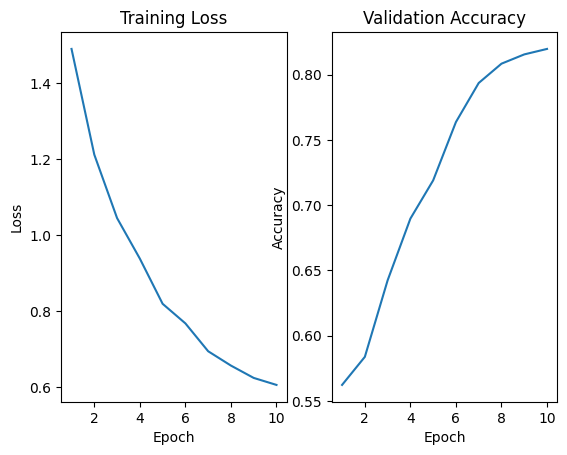

In [33]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2)

axes[0].plot(range(1, num_epochs + 1), losses)
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

axes[1].plot(range(1, num_epochs + 1), val_accuracies)
axes[1].set_title('Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

plt.show()

In [34]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.view(-1).to(device)
        outputs = model(images)

        predicted = torch.argmax(outputs, 1)
        total += labels.size(0)
        correct += torch.eq(predicted, labels).sum().item()

    acc = correct / total
    print(f'Accuracy: {100 * acc:.2f}%')

Accuracy: 79.22%


In [35]:
torch.save(model.state_dict(), 'trained_model.pth')